In [1]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Descarga de datos de Disney del 2023/01/01 al 2023/03/31

disney = yf.download("DIS", start="2023-01-01", end="2023-03-31")
disney = disney[['Close']]
disney

[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,DIS
Date,
2023-01-03,87.511131
2023-01-04,90.471771
2023-01-05,90.412743
2023-01-06,92.379959
2023-01-09,93.216011
...,...
2023-03-24,92.537338
2023-03-27,94.052086


Determina mediante la gráfica de Auto-Correlación Parcial y los estadísticos de Akaike y Bayesiano cuál sería el modelo auto-regresivo más adecuado para ajustar dicha serie de datos. Justifica claramente su respuesta mediante una base de entrenamiento del 70% de los datos. 

In [3]:
# Preparacion de los datos y dividir en entrenamiento (70%) y prueba (30%)
disney.index = pd.to_datetime(disney.index)
len_train = int(len(disney) * 0.7)
len_test = len(disney) - len_train

print(f"Entrenamiento (70%): {len_train}")
print(f"Prueba (30%): {len_test}")

Entrenamiento (70%): 42
Prueba (30%): 19


In [4]:
# Dividir los datos de entrenamiento y prueba
train = disney['Close'][0:len_train]
test = disney['Close'][len_train:]

print(f"Período entrenamiento: {train.index[0]} a {train.index[-1]}")
print(f"Período prueba: {test.index[0]} a {test.index[-1]}")

Período entrenamiento: 2023-01-03 00:00:00 a 2023-03-03 00:00:00
Período prueba: 2023-03-06 00:00:00 a 2023-03-30 00:00:00


In [5]:
# Análisis de Auto-Correlación (ACF) y Auto-Correlación Parcial (PACF)
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

ACF values:
 [ 1.00000000e+00  8.93400420e-01  8.00559553e-01  7.00645349e-01
  6.16627626e-01  5.20348363e-01  4.09500947e-01  2.95673749e-01
  2.14373647e-01  1.15850207e-01 -1.87714366e-04 -1.11439248e-01
 -2.24160999e-01 -3.01210049e-01 -3.59949072e-01 -4.17922755e-01
 -4.41431112e-01]


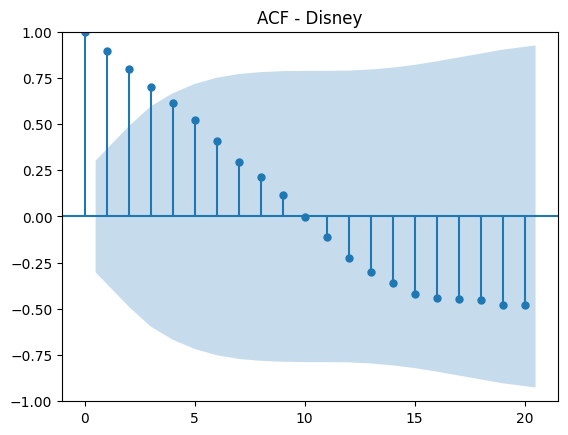

In [6]:
# Grafica de ACF 
acf_array = acf(train)
print("ACF values:\n", acf_array)

plot_acf(train, lags=20, alpha=0.05)
plt.title("ACF - Disney")
plt.show()

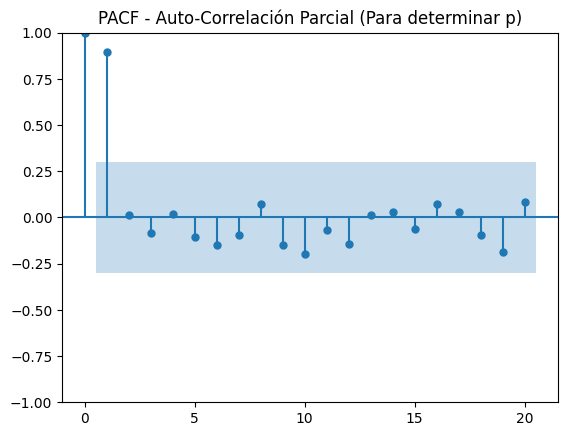

In [7]:
# Grafica PACF (Auto correlacion parcial) 

plot_pacf(train, lags=20, alpha=0.05)
plt.title("PACF - Auto-Correlación Parcial (Para determinar p)")
plt.show()

In [8]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

max_p = 7
AIC_values = np.zeros(max_p)
BIC_values = np.zeros(max_p)

for p in range(max_p):
    model = ARIMA(train, order=(p, 0, 0))  # AR(p)
    fitted_model = model.fit()
    AIC_values[p] = fitted_model.aic
    BIC_values[p] = fitted_model.bic

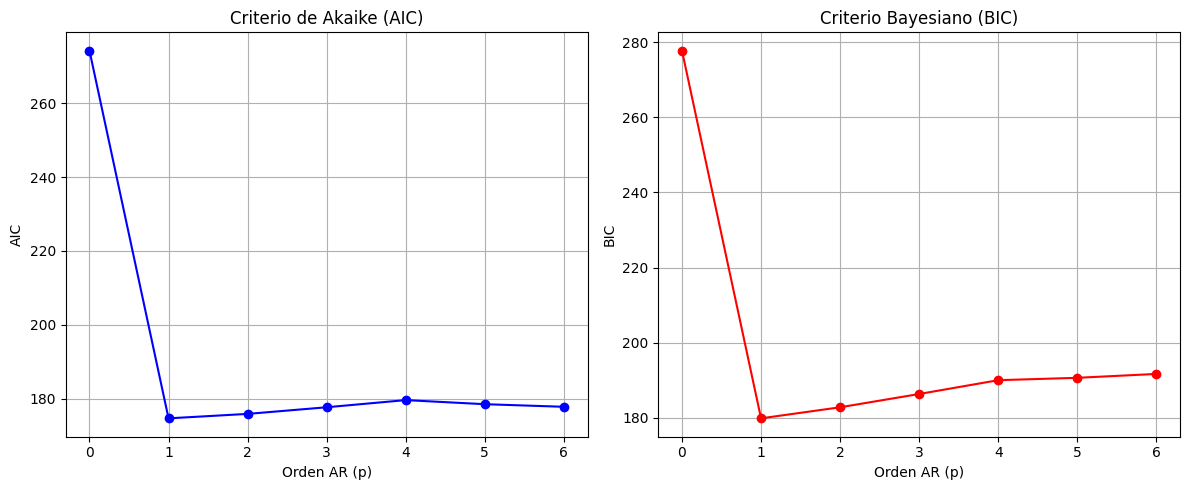

In [9]:
# Grafica de AIC y BIC

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(0, max_p), AIC_values, marker='o', color='blue')
plt.title('Criterio de Akaike (AIC)')
plt.xlabel('Orden AR (p)')
plt.ylabel('AIC')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(0, max_p), BIC_values, marker='o', color='red')
plt.title('Criterio Bayesiano (BIC)')
plt.xlabel('Orden AR (p)')
plt.ylabel('BIC')
plt.grid(True)

plt.tight_layout()
plt.show()

In [10]:
best_p_aic = np.argmin(AIC_values)
best_p_bic = np.argmin(BIC_values)

print(f"Mejor p según AIC es {best_p_aic} con un AIC de {AIC_values[best_p_aic]:.2f}")
print(f"Mejor p según BIC es {best_p_bic} con un BIC de {BIC_values[best_p_bic]:.2f}")

Mejor p según AIC es 1 con un AIC de 174.67
Mejor p según BIC es 1 con un BIC de 179.89


Pronostica los precios diarios por acción para el mes de Abril del 2023, tanto de manera puntual como mediante un intervalo de confianza del 90%, a partir del resultado obtenido en el punto anterior, p.

In [11]:
modelo_final = ARIMA(train, order=(best_p_aic, 0, 0))
modelo_ajustado = modelo_final.fit()

#  Resumen del modelo
print("=== RESUMEN DEL MODELO ===")
print(modelo_ajustado.summary())

=== RESUMEN DEL MODELO ===
                               SARIMAX Results                                
Dep. Variable:                    DIS   No. Observations:                   42
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -84.337
Date:                Sun, 14 Sep 2025   AIC                            174.675
Time:                        12:14:07   BIC                            179.888
Sample:                             0   HQIC                           176.586
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.5508      5.179     18.644      0.000      86.401     106.700
ar.L1          0.9715      0.032     30.170      0.000       0.908       1.035
sigma2         3.0333    

In [12]:
# Determinar días hábiles de abril 2023
# freq = B son los dias hábiles
fechas_abril = pd.date_range(start='2023-04-01', end='2023-04-30', freq='B')
num_dias_abril = len(fechas_abril)

print(f"{'Días hábiles en abril 2023':^35}: {num_dias_abril}")
print(f"{'Período de predicción':^35}: {fechas_abril[0]} a {fechas_abril[-1]}")

    Días hábiles en abril 2023     : 20
       Período de predicción       : 2023-04-03 00:00:00 a 2023-04-28 00:00:00


In [13]:
# Predicciones puntuales para abril 2023
predicciones_abril = modelo_ajustado.forecast(steps=num_dias_abril)

# Intervalos de confianza del 90%
forecast_result = modelo_ajustado.get_forecast(steps=num_dias_abril)
conf_int_90 = forecast_result.conf_int(alpha=0.10) 

print("=== PREDICCIONES PARA ABRIL 2023 ===")
print("Predicciones puntuales:")
print(predicciones_abril)
print("\nIntervalos de confianza 90%:")
print(conf_int_90)

=== PREDICCIONES PARA ABRIL 2023 ===
Predicciones puntuales:
42    99.398016
43    99.316847
44    99.237991
45    99.161384
46    99.086960
47    99.014659
48    98.944418
49    98.876180
50    98.809887
51    98.745484
52    98.682917
53    98.622133
54    98.563083
55    98.505715
56    98.449984
57    98.395841
58    98.343241
59    98.292141
60    98.242498
61    98.194270
Name: predicted_mean, dtype: float64

Intervalos de confianza 90%:
    lower DIS   upper DIS
42  96.533290  102.262742
43  95.322842  103.310851
44  94.414904  104.061079
45  93.669442  104.653325
46  93.031144  105.142777
47  92.471079  105.558238
48  91.971717  105.917119
49  91.521406  106.230953
50  91.111889  106.507885
51  90.737033  106.753934
52  90.392119  106.973714
53  90.073406  107.170860
54  89.777867  107.348299
55  89.502998  107.508433
56  89.246704  107.653264
57  89.007199  107.784483
58  88.782952  107.903531
59  88.572632  108.011651
60  88.375073  108.109923
61  88.189249  108.199292


In [14]:
# DataFrame con intervalos de confianza y predicciones
resultados_abril = pd.DataFrame({
    'Fecha': fechas_abril,
    'Predicción': predicciones_abril.values,
    'Límite_Inferior_90%': conf_int_90.iloc[:, 0].values,
    'Límite_Superior_90%': conf_int_90.iloc[:, 1].values
})

resultados_abril = resultados_abril.set_index('Fecha')
print(" Pronostico del mes de ABRIL 2023")
print(resultados_abril)

 Pronostico del mes de ABRIL 2023
            Predicción  Límite_Inferior_90%  Límite_Superior_90%
Fecha                                                           
2023-04-03   99.398016            96.533290           102.262742
2023-04-04   99.316847            95.322842           103.310851
2023-04-05   99.237991            94.414904           104.061079
2023-04-06   99.161384            93.669442           104.653325
2023-04-07   99.086960            93.031144           105.142777
2023-04-10   99.014659            92.471079           105.558238
2023-04-11   98.944418            91.971717           105.917119
2023-04-12   98.876180            91.521406           106.230953
2023-04-13   98.809887            91.111889           106.507885
2023-04-14   98.745484            90.737033           106.753934
2023-04-17   98.682917            90.392119           106.973714
2023-04-18   98.622133            90.073406           107.170860
2023-04-19   98.563083            89.777867           10

Responde ¿Qué tan exactos cree usted que serán sus predicciones? Justifique mediante el uso de indicadores de bondad de ajuste. 

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

predicciones_train = modelo_ajustado.fittedvalues
predicciones_test = modelo_ajustado.forecast(steps=len(test))
train_values = train.values
pred_train_values = predicciones_train.values
test_values = test.values
pred_test_values = predicciones_test.values

# Calculo de métricas
mse_train = mean_squared_error(train, predicciones_train)
mae_train = mean_absolute_error(train, predicciones_train)
rmse_train = np.sqrt(mse_train)
mape_train = np.mean(np.abs((train_values - pred_train_values) / train_values)) * 100

mse_test = mean_squared_error(test, predicciones_test)
mae_test = mean_absolute_error(test, predicciones_test)
rmse_test = np.sqrt(mse_test)
mape_test = np.mean(np.abs((test_values - pred_test_values) / test_values)) * 100

# tabla comparativa
metricas_df = pd.DataFrame({
    'Estadísticos': ['MSE', 'MAE', 'RMSE', 'MAPE (%)'],
    'Entrenamiento': [f"{mse_train:.2f}", f"${mae_train:.2f}", f"{rmse_train:.2f}", f"{mape_train:.2f}%"],
    'Prueba': [f"{mse_test:.2f}", f"${mae_test:.2f}", f"{rmse_test:.2f}", f"{mape_test:.2f}%"]
})

print(f"{'Estadísticos':^15} {'Entrenamiento':^15} {'Prueba':^15}")
print("-" * 50)
for i, row in metricas_df.iterrows():
    print(f"{row['Estadísticos']:^15} {row['Entrenamiento']:^15} {row['Prueba']:^15}")


 Estadísticos    Entrenamiento      Prueba     
--------------------------------------------------
      MSE            4.87            27.23     
      MAE            $1.51           $4.75     
     RMSE            2.21            5.22      
   MAPE (%)          6.75%           5.14%     


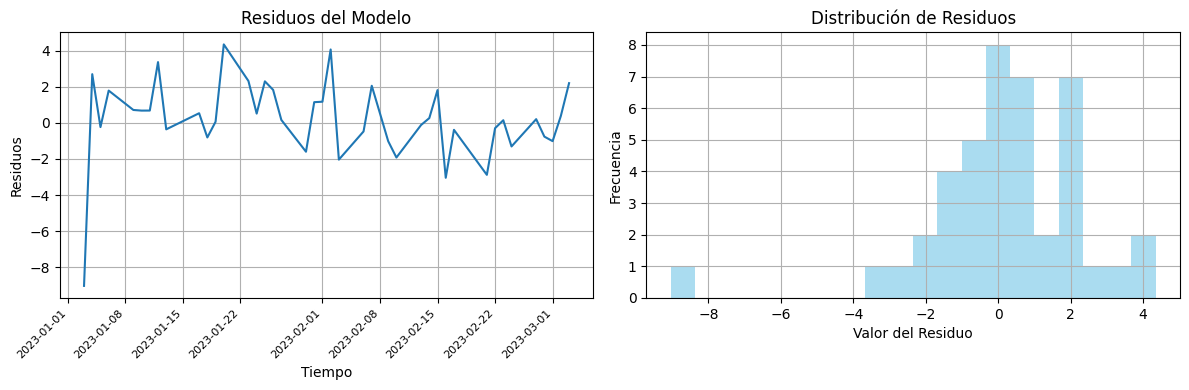

 Media de residuos  | 0.209093
Desviación estándar | 2.1968


In [16]:
# Análisis de residuos del modelo
residuos = modelo_ajustado.resid

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(residuos)
plt.title('Residuos del Modelo')
plt.xlabel('Tiempo')
plt.xticks(rotation=45, fontsize=8, ha='right')  
plt.ylabel('Residuos')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuos, bins=20, alpha=0.7, color='skyblue')
plt.title('Distribución de Residuos')
plt.xlabel('Valor del Residuo')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"{'Media de residuos':^19} | {np.mean(residuos):.6f}")
print(f"{'Desviación estándar':^5} | {np.std(residuos):.4f}")

Grafica los resultados del punto anterior,  distinguiendo claramente por colores cada grupo de datos empleados en su análisis.

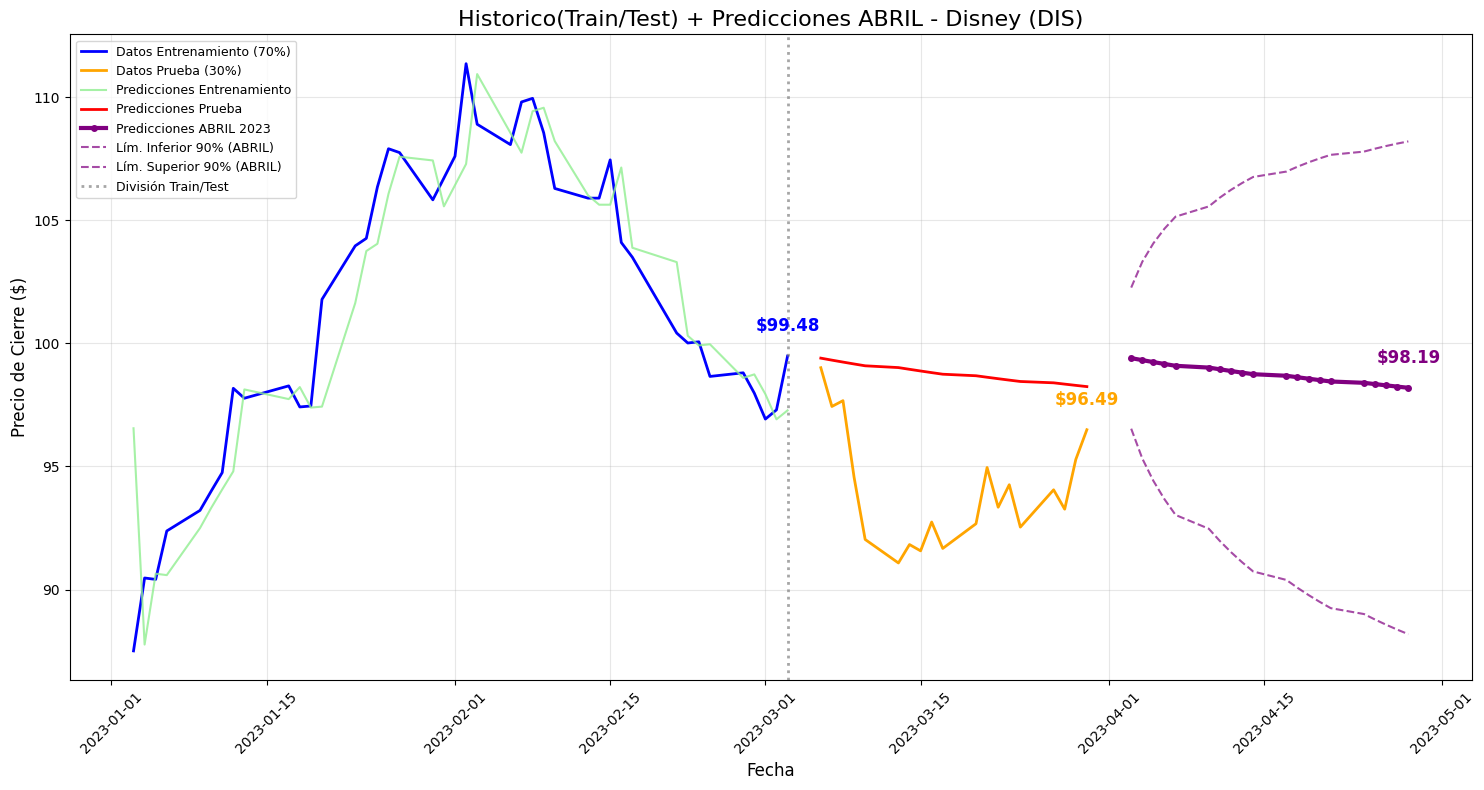

Análisis de Resultados:
Último precio entrenamiento: $99.48
Último precio prueba: $96.49
Última predicción ABRIL: $98.19
Cambio train→Prediccion: $-1.70


In [17]:
# Grafica de resultados 

ultimo_precio_train = float(train.values[-1])
ultimo_precio_test = float(test.values[-1])
ultimo_precio_predicho_abril = float(predicciones_abril.values[-1])
estimacion = float(ultimo_precio_test - ultimo_precio_predicho_abril)

# Intervalos de confianza para el conjunto de prueba (marzo)
forecast_result_test = modelo_ajustado.get_forecast(steps=len(test))
conf_int_test = forecast_result_test.conf_int(alpha=0.10)

plt.figure(figsize=(15, 8))

# Datos históricos
plt.plot(train.index, train.values, label='Datos Entrenamiento (70%)', color='blue', linewidth=2)
plt.plot(test.index, test.values, label='Datos Prueba (30%)', color='orange', linewidth=2)

# Predicciones históricas
plt.plot(train.index, predicciones_train, label='Predicciones Entrenamiento', color='lightgreen', alpha=0.8)
plt.plot(test.index, predicciones_test, label='Predicciones Prueba', color='red', linewidth=2)

# Predicciones de ABRIL
plt.plot(fechas_abril, predicciones_abril.values, 
         label='Predicciones ABRIL 2023', color='purple', linewidth=3, marker='o', markersize=4)
plt.plot(fechas_abril, conf_int_90.iloc[:, 0].values, 
         label='Lím. Inferior 90% (ABRIL)', color='purple', linestyle='--', alpha=0.7)
plt.plot(fechas_abril, conf_int_90.iloc[:, 1].values, 
         label='Lím. Superior 90% (ABRIL)', color='purple', linestyle='--', alpha=0.7)

plt.axvline(x=train.index[-1], color='gray', linestyle=':', alpha=0.7, linewidth=2, label='División Train/Test')
plt.text(train.index[-1], ultimo_precio_train + 1, f'${ultimo_precio_train:.2f}', 
         fontsize=12, fontweight='bold', color='blue', ha='center')
plt.text(test.index[-1], ultimo_precio_test + 1, f'${ultimo_precio_test:.2f}', 
         fontsize=12, fontweight='bold', color='orange', ha='center')

# Precio predicho de abril
ultimo_precio_predicho_abril = float(predicciones_abril.values[-1])
plt.text(fechas_abril[-1], ultimo_precio_predicho_abril + 1, f'${ultimo_precio_predicho_abril:.2f}', 
         fontsize=12, fontweight='bold', color='purple', ha='center')

plt.title('Historico(Train/Test) + Predicciones ABRIL - Disney (DIS)', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre ($)', fontsize=12)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estadísticas
print(f"Análisis de Resultados:")
print(f"Último precio entrenamiento: ${ultimo_precio_train:.2f}")
print(f"Último precio prueba: ${ultimo_precio_test:.2f}")
print(f"Última predicción ABRIL: ${ultimo_precio_predicho_abril:.2f}")
print(f"Cambio train→Prediccion: ${estimacion:+.2f}")

In [18]:
# Grafica Real del periodo 2023-04-01 a 2023-04-28
disney_real = yf.download("DIS", start="2023-04-01", end="2023-04-28")
disney_real = disney_real[['Close']]

[*********************100%***********************]  1 of 1 completed


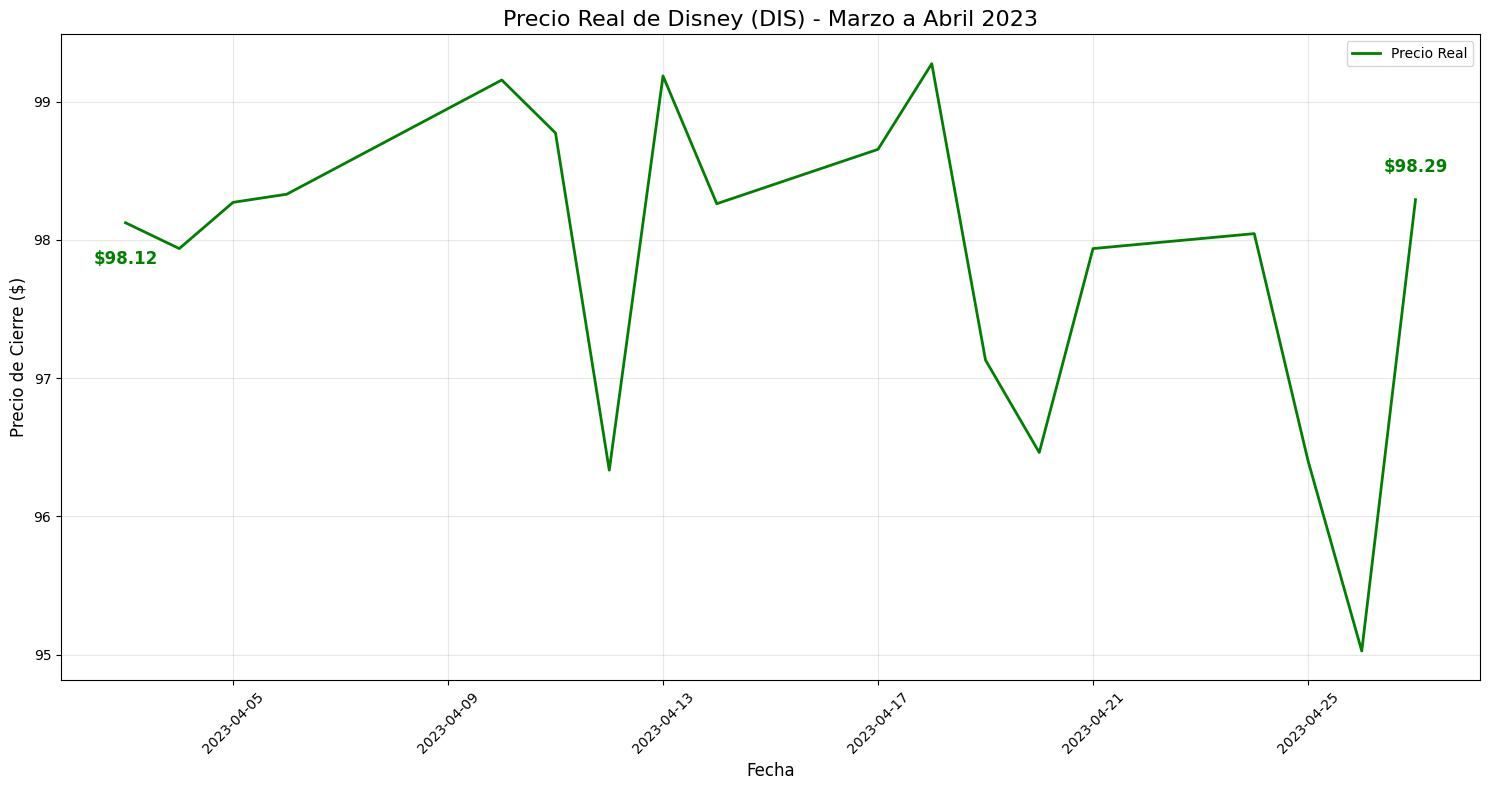


 -- Valores Reales --
Último precio real (28 abril): $98.29
Última predicción (28 abril): $98.19
Diferencia Predicción vs Real: $+0.10


In [19]:
# Formato de la gráfica del precio real
primer_precio_real = float(disney_real['Close'].values[0])
ultimo_precio_real = float(disney_real['Close'].values[-1])

plt.figure(figsize=(15, 8))
plt.plot(disney_real.index, disney_real['Close'], label='Precio Real', color='green', linewidth=2)
plt.title('Precio Real de Disney (DIS) - Marzo a Abril 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre ($)', fontsize=12)
plt.text(disney_real.index[0], primer_precio_real - 0.3, f'${primer_precio_real:.2f}', 
         fontsize=12, fontweight='bold', color='green', ha='center')
plt.text(disney_real.index[-1], ultimo_precio_real + 0.2, f'${ultimo_precio_real:.2f}', 
         fontsize=12, fontweight='bold', color='green', ha='center')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estadísticas
ultimo_precio_predicho_abril = float(predicciones_abril.values[-1])
disney_real_abril = disney_real[disney_real.index >= '2023-04-03']
ultimo_precio_real_abril = float(disney_real_abril['Close'].values[-1])

print(f"\n -- Valores Reales --")
print(f"Último precio real (28 abril): ${ultimo_precio_real_abril:.2f}")
print(f"Última predicción (28 abril): ${ultimo_precio_predicho_abril:.2f}")

Valor_prediccion_vs_real = ultimo_precio_real_abril - ultimo_precio_predicho_abril
print(f"Diferencia Predicción vs Real: ${Valor_prediccion_vs_real:+.2f}")

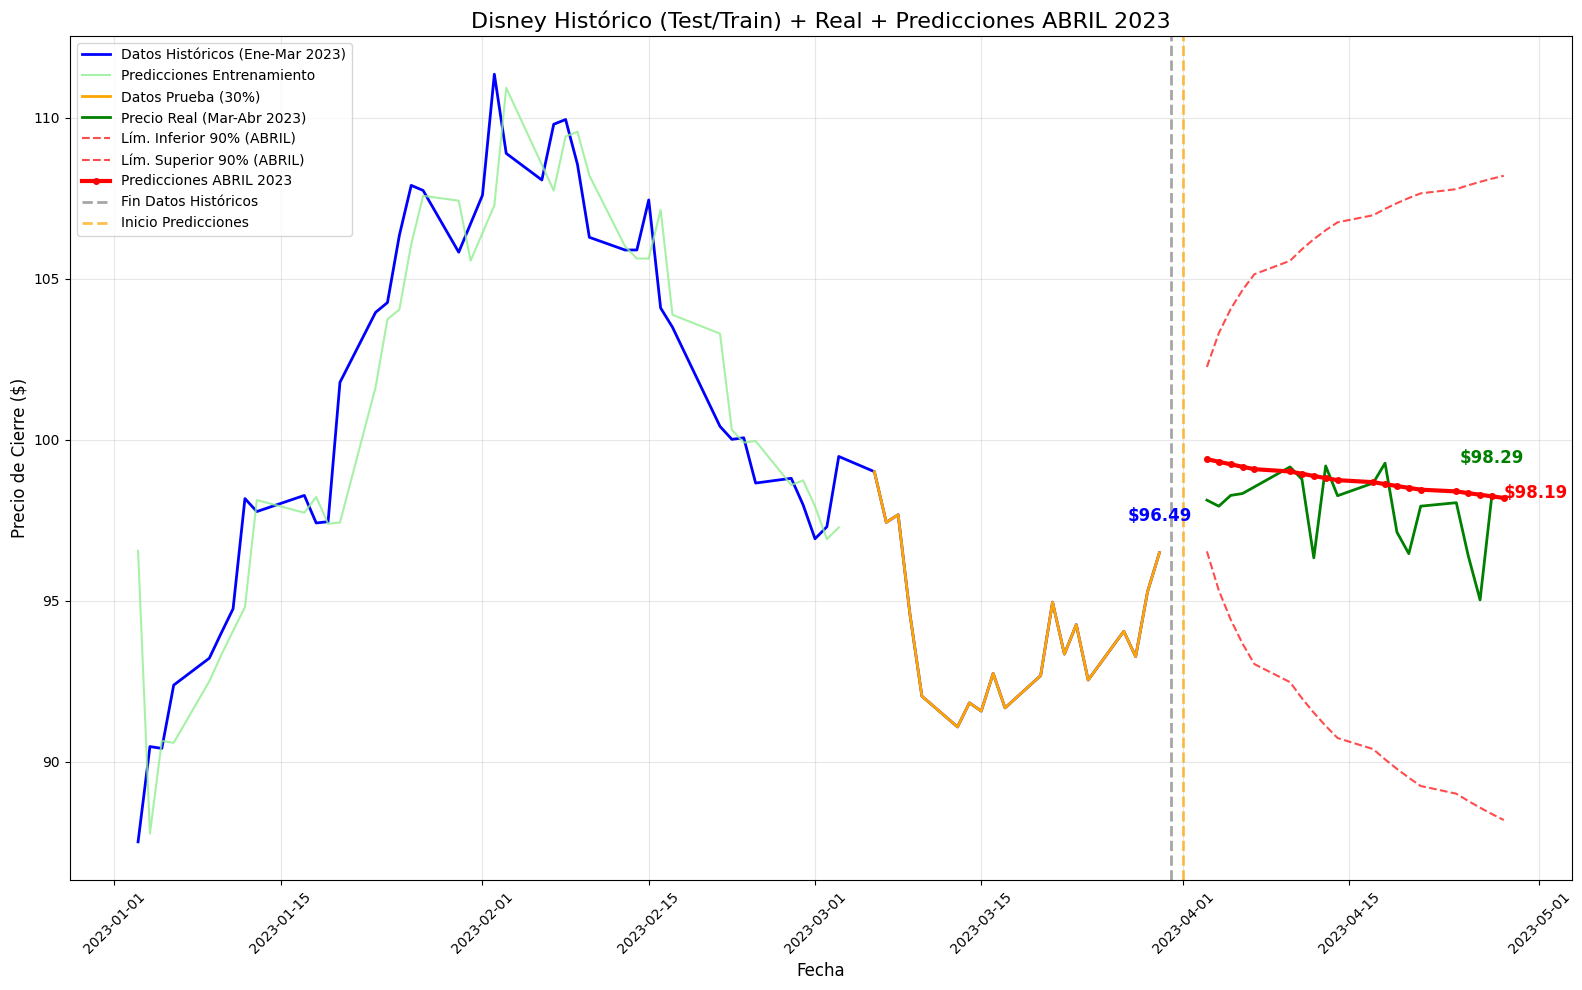


COMPARATIVAS:
Último precio histórico (31 mar): $96.49
Último precio real (28 abr):      $98.29
Última predicción (28 abr):       $98.19
Cambio real Mar→Abr:     $+1.80
Error de predicción:     $+0.10
Error porcentual:        +0.10%


In [27]:
# Gráfica de Históricos + Reales + Predicciones
plt.figure(figsize=(16, 10))

# 1. DATOS HISTÓRICOS (Enero - Marzo 2023)
plt.plot(disney.index, disney['Close'], label='Datos Históricos (Ene-Mar 2023)', 
         color='blue', linewidth=2)
plt.plot(train.index, predicciones_train, label='Predicciones Entrenamiento', color='lightgreen', alpha=0.8)
plt.plot(test.index, test.values, label='Datos Prueba (30%)', color='orange', linewidth=2)

# 2. DATOS REALES COMPLETOS (Marzo - Abril 2023) 
plt.plot(disney_real.index, disney_real['Close'], label='Precio Real (Mar-Abr 2023)', 
         color='green', linewidth=2)

# 3. PREDICCIONES DE ABRIL con intervalos de confianza
plt.plot(fechas_abril, conf_int_90.iloc[:, 0].values, 
         label='Lím. Inferior 90% (ABRIL)', color='red', linestyle='--', alpha=0.7)
plt.plot(fechas_abril, conf_int_90.iloc[:, 1].values, 
         label='Lím. Superior 90% (ABRIL)', color='red', linestyle='--', alpha=0.7)
plt.plot(fechas_abril, predicciones_abril.values, 
         label='Predicciones ABRIL 2023', color='red', linewidth=3, marker='o', markersize=4)

# 4. LÍNEAS DIVISORIAS
plt.axvline(x=pd.to_datetime('2023-03-31'), color='gray', linestyle='--', 
            alpha=0.7, linewidth=2, label='Fin Datos Históricos')
plt.axvline(x=pd.to_datetime('2023-04-01'), color='orange', linestyle='--', 
            alpha=0.7, linewidth=2, label='Inicio Predicciones')

# Último precio histórico
ultimo_historico = float(disney['Close'].values[-1])
plt.text(disney.index[-1], ultimo_historico + 1, f'${ultimo_historico:.2f}', 
         fontsize=12, fontweight='bold', color='blue', ha='center')

# Último precio real de abril
plt.text(disney_real.index[-1], ultimo_precio_real_abril + 1, f'${ultimo_precio_real_abril:.2f}', 
         fontsize=12, fontweight='bold', color='green', ha='center')

# Última predicción de abril
plt.text(fechas_abril[-1], ultimo_precio_predicho_abril, f'${ultimo_precio_predicho_abril:.2f}', 
         fontsize=12, fontweight='bold', color='red', ha='left')

plt.title('Disney Histórico (Test/Train) + Real + Predicciones ABRIL 2023', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre ($)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estadísticas comparativas mejoradas
print(f"\nCOMPARATIVAS:")
print(f"="*50)
print(f"Último precio histórico (31 mar): ${ultimo_historico:.2f}")
print(f"Último precio real (28 abr):      ${ultimo_precio_real_abril:.2f}")
print(f"Última predicción (28 abr):       ${ultimo_precio_predicho_abril:.2f}")
print(f"="*50)
print(f"Cambio real Mar→Abr:     ${ultimo_precio_real_abril - ultimo_historico:+.2f}")
print(f"Error de predicción:     ${Valor_prediccion_vs_real:+.2f}")
print(f"Error porcentual:        {(Valor_prediccion_vs_real/ultimo_precio_real_abril)*100:+.2f}%")